In [19]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../kaggle_prediction_library/') 
import preprocess
import feature_engineering
import submission
import validation
from sklearn.model_selection import train_test_split

# from hyperopt import tpe, fmin, Trials
# import hyperopt.hp as hp

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.feature_selection import chi2
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import brier_score_loss
from sklearn.pipeline import make_pipeline



In [20]:
to_predict_mens = pd.read_csv("to_predict_mens.csv")

### Prepare data 

In [21]:
def prepare_data(to_predict_mens, season):

    to_predict_mens_first_round_train = to_predict_mens[(to_predict_mens["GameRound"] == 1)
                                                        & (to_predict_mens.final_odds.notnull())
                                                        & (to_predict_mens.Season < season)
                                                        ].copy()
    
    to_predict_mens_train = to_predict_mens[(to_predict_mens.Season < season)].copy()

    to_predict_mens_first_round_test = to_predict_mens[(to_predict_mens.Season == season)
                                                    & (to_predict_mens.GameRound == 1)
                                                    & (to_predict_mens.final_odds.notnull())
                                                    ].copy()

    to_predict_mens_other_rounds_test = to_predict_mens[(to_predict_mens.Season == season)
                                                    & (to_predict_mens.GameRound > 1)
                                                    ].copy()
    
    return to_predict_mens_first_round_train, to_predict_mens_train, to_predict_mens_first_round_test, to_predict_mens_other_rounds_test
    


### Odds Model Training

In [22]:
def train_odds_model(to_predict_mens_first_round_train):

    best_params = {"C": .1}
    model = LogisticRegression(**best_params)
    pipeline = make_pipeline(StandardScaler(), model)
    odds_model = pipeline.fit(to_predict_mens_first_round_train[["final_odds"]], to_predict_mens_first_round_train["Outcome"])
    
    return odds_model


### Statistics Model Training

In [23]:
def train_statistics_model(to_predict_mens_train, statistics_features):

    best_params = {"C": .1}
    model = LogisticRegression(**best_params)
    pipeline = make_pipeline(StandardScaler(), model)
    statistics_model = pipeline.fit(to_predict_mens_train[statistics_features], to_predict_mens_train["Outcome"])

    return statistics_model


### Inference

In [24]:
def inference(to_predict_mens_first_round_test, to_predict_mens_other_rounds_test, odds_model, statistics_model, features):

    pred_proba = odds_model.predict_proba(to_predict_mens_first_round_test[["final_odds"]].copy())[:,1]
    to_predict_mens_first_round_test["odds_pred"] = pred_proba

    pred_proba = statistics_model.predict_proba(to_predict_mens_first_round_test[features].copy())[:,1]
    to_predict_mens_first_round_test["statistics_pred"] = pred_proba

    to_predict_mens_first_round_test["Pred"] = (to_predict_mens_first_round_test.odds_pred * .75) + \
                                                (to_predict_mens_first_round_test.statistics_pred * .25)
    

   

    pred_proba = statistics_model.predict_proba(to_predict_mens_other_rounds_test[features].copy())[:,1]
    to_predict_mens_other_rounds_test["Pred"] = pred_proba

    mens_sub = pd.concat([to_predict_mens_first_round_test[["ID", "Pred"]],
            to_predict_mens_other_rounds_test[["ID", "Pred"]]], axis=0)
    
    return mens_sub


### Train Mens Models

In [25]:
statistics_features = ['t1_adj_margin', 't2_adj_margin', 't1_final_rank', 't2_final_rank', 't1_OrdinalRank', 't2_OrdinalRank']

to_predict_mens_first_round_train, to_predict_mens_train, to_predict_mens_first_round_test, to_predict_mens_other_rounds_test= prepare_data(to_predict_mens, 2024)
odds_model = train_odds_model(to_predict_mens_first_round_train)
statistics_model = train_statistics_model(to_predict_mens_train, statistics_features)


### Predict / Evaluate with Odds

In [69]:
def get_only_round1_games(df):
    return df[
        ( (df.t1_Seed == 1) & (df.t2_Seed == 16) ) |
        ( (df.t1_Seed == 2) & (df.t2_Seed == 15) ) |
        ( (df.t1_Seed == 3) & (df.t2_Seed == 14) ) |
        ( (df.t1_Seed == 4) & (df.t2_Seed == 13) ) |
        ( (df.t1_Seed == 5) & (df.t2_Seed == 12) ) |
        ( (df.t1_Seed == 6) & (df.t2_Seed == 11) ) |
        ( (df.t1_Seed == 7) & (df.t2_Seed == 10) ) |
        ( (df.t1_Seed == 8) & (df.t2_Seed == 9) ) |

        ( (df.t2_Seed == 1) & (df.t1_Seed == 16) ) |
        ( (df.t2_Seed == 2) & (df.t1_Seed == 15) ) |
        ( (df.t2_Seed == 3) & (df.t1_Seed == 14) ) |
        ( (df.t2_Seed == 4) & (df.t1_Seed == 13) ) |
        ( (df.t2_Seed == 5) & (df.t1_Seed == 12) ) |
        ( (df.t2_Seed == 6) & (df.t1_Seed == 11) ) |
        ( (df.t2_Seed == 7) & (df.t1_Seed == 10) ) |
        ( (df.t2_Seed == 8) & (df.t1_Seed == 9) ) 
    ]


In [26]:
to_predict_women = pd.read_csv("to_predict_women.csv")


In [70]:
first_round_odds_to_predict_women = get_only_round1_games(to_predict_women[(to_predict_women.final_odds.notnull())])

In [71]:
y_prob = odds_model.predict_proba(first_round_odds_to_predict_women[["final_odds"]])


In [72]:
first_round_odds_to_predict_women["y_prob"] = y_prob[:,1].copy()
loss = brier_score_loss(first_round_odds_to_predict_women["Outcome"], y_prob[:,1])

In [73]:
loss

0.1024437246524254

In [74]:
first_round_odds_to_predict_women[["Season", "t1_TeamName", "t2_TeamName", "final_odds", 't1_Seed', 't2_Seed', "seed_diff", "y_prob", "Outcome"]]

,Season,t1_TeamName,t2_TeamName,final_odds,t1_Seed,t2_Seed,seed_diff,y_prob,Outcome
764,2023,Arizona,West Virginia,-8.5,7,10,-3,0.761405,1
765,2023,Georgia,Florida St,1.5,10,7,3,0.449029,1
766,2023,Iowa,SE Louisiana,-29.5,2,15,-13,0.982483,1
767,2023,LSU,Hawaii,-29.0,3,14,-11,0.981268,1
768,2023,Maryland,Holy Cross,-23.5,2,15,-13,0.961130,1
...,...,...,...,...,...,...,...,...,...
1752,2024,WI Green Bay,Tennessee,7.5,11,6,5,0.264328,0
1753,2024,Cal Baptist,UCLA,27.5,15,2,13,0.022897,0
1754,2024,TAM C. Christi,USC,32.5,16,1,15,0.011704,0
1755,2024,S Dakota St,Utah,8.5,12,5,7,0.238651,0


### Predict / Evaluate normal

In [93]:
to_predict_women_train = to_predict_women[to_predict_women.Season < 2023].copy()

to_predict_women_test = get_only_round1_games(
                        to_predict_women[(to_predict_women.Season >= 2023) & (to_predict_women.final_odds.notnull())].copy()
                            )

In [102]:
to_predict_women_test["y_prob_odds"] = first_round_odds_to_predict_women["y_prob"]

In [106]:
to_predict_women_test["odds_better"] = np.where(
                ( (to_predict_women_test.y_prob_odds > to_predict_women_test.pred) & (to_predict_women_test["Outcome"] == 1)) |
                ( (to_predict_women_test.y_prob_odds < to_predict_women_test.pred) & (to_predict_women_test["Outcome"] == 0)), 1, 0)

In [111]:
to_predict_women_test["abs_diff"] = np.abs(to_predict_women_test.pred - to_predict_women_test.y_prob_odds)

In [ ]:
to_predict_women_test.groupby("odds_better").count()["ID"]

odds_better
0    56
1    72
Name: ID, dtype: int64

In [113]:
to_predict_women_test.groupby("odds_better").mean()["abs_diff"]

/var/folders/h5/f91pbgmj0rj6v0ls3y8zc5l40000gn/T/ipykernel_97154/2810962495.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  to_predict_women_test.groupby("odds_better").mean()["abs_diff"]


odds_better
0    0.073204
1    0.039150
Name: abs_diff, dtype: float64

In [116]:
to_predict_women_test.columns

Index(['Unnamed: 0', 'type', 'ID', 'Pred', 'Season', 'Team1', 'Team2',
       'Outcome', 'Gender', 'margin', 't1_Seed', 't2_Seed', 'seed_diff',
       't1_adj_oe', 't1_adj_de', 't1_adj_margin', 't2_adj_oe', 't2_adj_de',
       't2_adj_margin', 'GameRound', 't1_TeamName', 't2_TeamName',
       'final_odds', 'pred', 'y_prob_odds', 'odds_better', 'abs_diff'],
      dtype='object')

In [125]:
to_predict_women_test.sort_values(by="abs_diff", ascending=False)[['Season', 't1_TeamName', 't2_TeamName', 't1_Seed', 't2_Seed', "Outcome", "odds_better", "final_odds", "pred", "y_prob_odds", "abs_diff"]].head(50)

,Season,t1_TeamName,t2_TeamName,t1_Seed,t2_Seed,Outcome,odds_better,final_odds,pred,y_prob_odds,abs_diff
771,2023,Mississippi St,Creighton,11,6,1,1,1.0,0.227294,0.465966,0.238672
1665,2023,Creighton,Mississippi St,6,11,0,1,-1.0,0.772706,0.534110,0.238595
1751,2024,Arizona,Syracuse,11,6,0,0,-1.5,0.360794,0.551047,0.190253
857,2024,Syracuse,Arizona,6,11,1,0,1.5,0.639206,0.449029,0.190177
1675,2023,MTSU,Colorado,11,6,0,0,-2.0,0.382724,0.567867,0.185143
781,2023,Colorado,MTSU,6,11,1,0,2.0,0.617276,0.432209,0.185067
1664,2023,Gonzaga,Mississippi,9,8,0,0,-1.0,0.359500,0.534110,0.174611
770,2023,Mississippi,Gonzaga,8,9,1,0,1.0,0.640500,0.465966,0.174534
1680,2023,Drake,Louisville,12,5,0,0,3.5,0.217089,0.382820,0.165732
786,2023,Louisville,Drake,5,12,1,0,-3.5,0.782911,0.617252,0.165659


In [ ]:
to_predict_women_test[to_predict_women_test.odds_better == 0][['t1_TeamName', 't2_TeamName', "Outcome", "final_odds", "pred", "y_prob_odds"]].head(50)

,t1_TeamName,t2_TeamName,Outcome,final_odds,pred,y_prob_odds,abs_diff
768,Maryland,Holy Cross,1,-23.5,0.965610,0.961130,0.004480
769,Michigan,UNLV,1,-3.0,0.760384,0.601005,0.159379
770,Mississippi,Gonzaga,1,1.0,0.640500,0.465966,0.174534
772,Notre Dame,Southern Utah,1,-21.5,0.956882,0.949545,0.007338
773,Princeton,NC State,1,4.5,0.404868,0.351126,0.053742
776,South Florida,Marquette,1,-3.0,0.644391,0.601005,0.043387
778,Utah,Gardner Webb,1,-23.5,0.962819,0.961130,0.001689
779,Virginia Tech,Chattanooga,1,-23.5,0.981852,0.961130,0.020722
780,Baylor,Alabama,1,1.5,0.543182,0.449029,0.094153
781,Colorado,MTSU,1,2.0,0.617276,0.432209,0.185067


In [95]:
statistics_features = ['seed_diff', 't1_adj_margin', 't2_adj_margin']
best_params = {"C": .1}
model = LogisticRegression(**best_params)
pipeline = make_pipeline(StandardScaler(), model)
statistics_model = pipeline.fit(to_predict_women_train[statistics_features], to_predict_women_train["Outcome"])
pred_proba = statistics_model.predict_proba(to_predict_women_test[statistics_features].copy())[:,1]


In [96]:
loss = brier_score_loss(to_predict_women_test["Outcome"], pred_proba)

In [97]:
to_predict_women_test["pred"] = pred_proba

In [98]:
loss

0.09789160722675985

In [134]:
to_predict_women_test.columns

Index(['Unnamed: 0', 'type', 'ID', 'Pred', 'Season', 'Team1', 'Team2',
       'Outcome', 'Gender', 'margin', 't1_Seed', 't2_Seed', 'seed_diff',
       't1_adj_oe', 't1_adj_de', 't1_adj_margin', 't2_adj_oe', 't2_adj_de',
       't2_adj_margin', 'GameRound', 't1_TeamName', 't2_TeamName',
       'final_odds', 'pred', 'y_prob_odds', 'odds_better', 'abs_diff'],
      dtype='object')

### Exploring a blend

Matplotlib is building the font cache; this may take a moment.


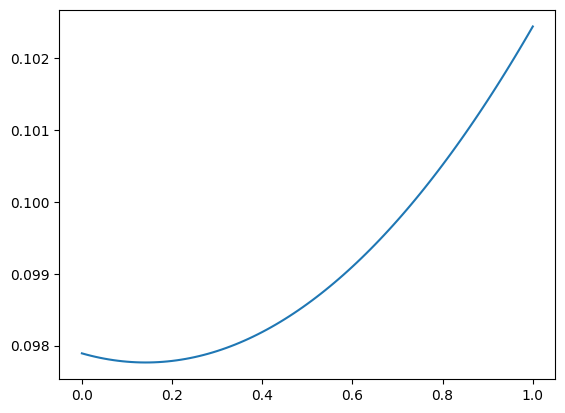

In [137]:
results = []

for i in range(0, 101):
    i = i/100
    w1 = i
    w2 = 1 - i
    to_predict_women_test["combined_prob"] = to_predict_women_test["y_prob_odds"] * w1 + to_predict_women_test["pred"] * w2
    score = brier_score_loss(to_predict_women_test["Outcome"], to_predict_women_test["combined_prob"])
    results.append([w1, w2, score])

score_df = pd.DataFrame(results, columns = ["Odds Weight", "Stats Weight", "Score"])

import matplotlib.pyplot as plt
plt.plot(score_df["Odds Weight"], score_df.Score)

### Takeaways

Overall, the performance of the models is similar, but the statistical model is still better.

Interestingly, the odds model is better more often, but when the statistical model is better its better by a larger margin.

Of course, this analysis only covers two years, so it's hard to draw any major conclusions, but there doesn't seem to be a compelling enough case to use the odds data.